# Basics of Markov chains

In this notebook we review basic tasks related to Markov chains:
* parameter estimation
* finding marginal probabilities
* finding the most probable outcome

**Supporting materials:**
*  [belief_propagation_in_a_chain.ipynb](tutorials/belief_propagation_in_a_chain.ipynb) 

In [28]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import string

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I.  Estimating parameters of homogeneous Markov chains

<img src = 'illustrations/homogenous-markov-chain.png' width=100%>

Recall that in order to estimate initial probabilities $\boldsymbol{\beta}[\cdot]$ and transition probabilities $\boldsymbol{\alpha}[\cdot,\cdot]$, we need to count starting letters and bigrams.
After that we can use maximum likelihood estimates

\begin{align*}
\beta[u_1]  &= \frac{k(\bullet,u_1)}{k(\bullet,*)}\\
\alpha[u_1 u_2] &= \frac{k(u_1,u_2)}{k(u_1,*)}
\end{align*}

or Laplace smoothing estimates

\begin{align*}
\beta[u_1]  &= \frac{k(\bullet,u_1)+c}{k(\bullet,*)+mc}\\
\alpha[u_1 u_2] &= \frac{k(u_1,u_2)+c}{k(u_1,*)+mc}
\end{align*}

where $\bullet$ denotes the start of the string, $c\geq 0$ is the Laplace smoothing constant and $m$ is the total number of characters. 

### Preprocessing

As a practical engineering trick we convert all characters to lower case and map all values outside the range `0-9a-z` to the symbol `?`, which will represent all characters we do not want to treat. For obvious reasons, this approach is valid only for English tests.

In [2]:
df = pd.read_csv('data/eng_training_set.csv', header=None, names=['words'])
old = head(df).copy()
df['words'] = df['words'].str.lower().str.replace('[^0-9a-z]','?', regex=True)
mdisplay([old, head(df)],['Initial data', 'Processed data'])

Initial data Processed data 
 
 
 words 
 
 
 
 
 friendship 
 
 
 guess 
 
 
 accounts 
 
 
 it's 
 
 
 me 
 
 
 
 
 
 words 
 
 
 
 
 friendship 
 
 
 guess 
 
 
 accounts 
 
 
 it?s 
 
 
 me

### Counts of starting letters

In [3]:
(DataFrame(df['words'].str.lower()
                          .str[0].value_counts())
 .reset_index()
)

,words,count
0,t,164
1,a,101
2,i,92
3,w,72
4,s,63
5,o,51
6,b,48
7,f,42
8,c,41
9,m,37


In [4]:
start_counts = DataFrame(df['words'].str.lower().str[0].value_counts()).rename_axis('u1')
display(head(start_counts))

,count
u1,
t,164
a,101
i,92
w,72
s,63


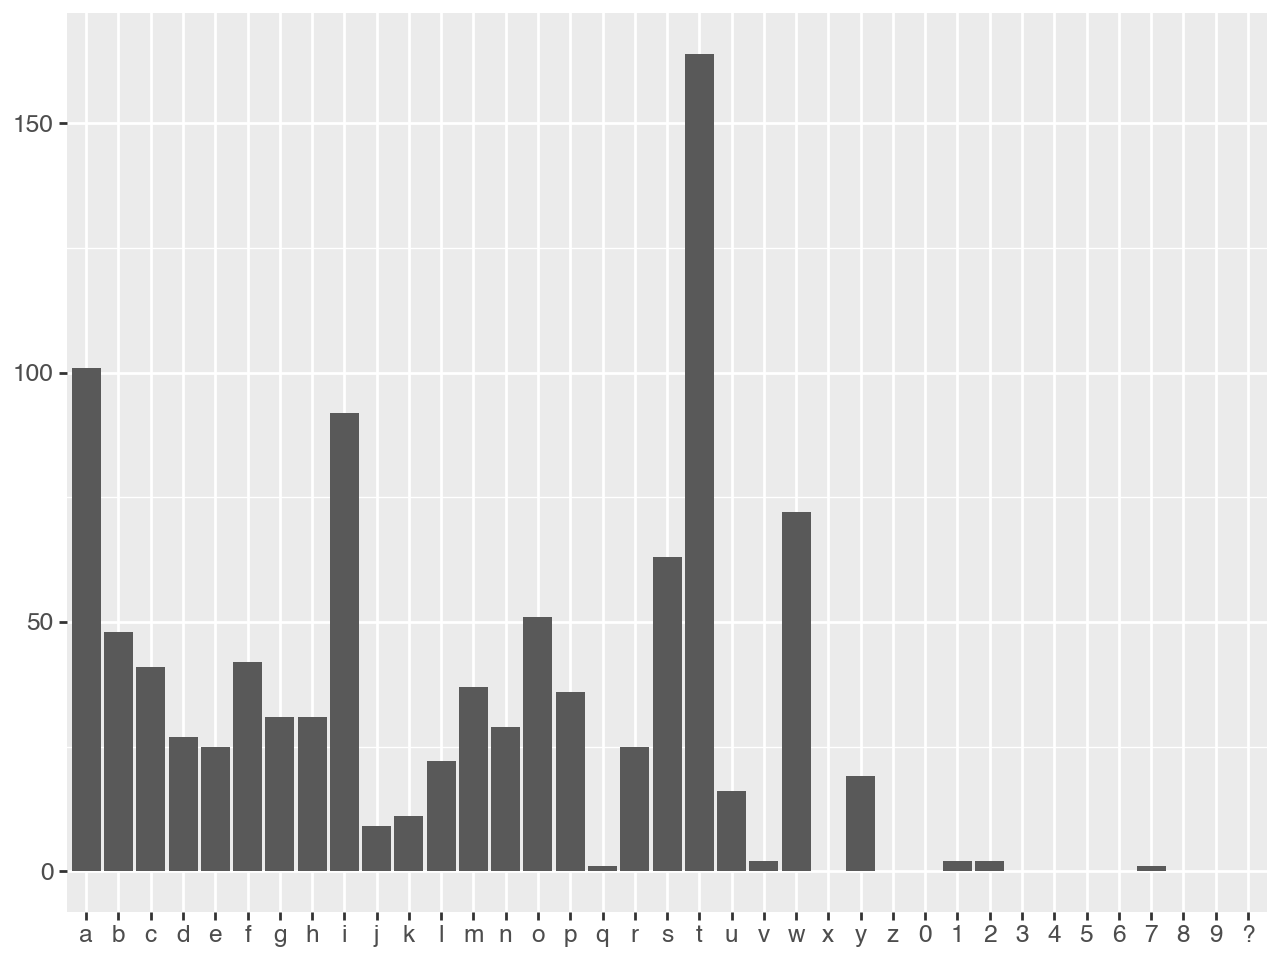

In [5]:
LetterType = CategoricalDtype(list(string.ascii_lowercase) + list(string.digits) + ['?'], ordered = True)

p = ggplot(start_counts.reset_index().assign(u1 = lambda df: df['u1'].astype(LetterType)))
p = p + geom_col(aes(x = 'u1', y = 'count'))
p + scale_x_discrete(name = '', drop = False) + scale_y_continuous(name = '')

### Count bigrams

In [6]:
def ngrams(text:str, n:int=2) -> List[str]:
    '''
    Returns a list of ngrams for the text 
    
    Inspired by http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
    '''
    
    return [''.join(x) for x in zip(*[text[i:] for i in range(n)])]

In [7]:
print(ngrams('abcdef', 1))
print(ngrams('abcdef', 2))
print(ngrams('abcdef', 3))

['a', 'b', 'c', 'd', 'e', 'f']
['ab', 'bc', 'cd', 'de', 'ef']
['abc', 'bcd', 'cde', 'def']


In [8]:
#df['words'].str.lower().apply(ngrams).sum()

In [9]:
bigram_counts = (DataFrame(
                    Series(
                        df['words'].str.lower()
                        .apply(ngrams).sum())
                    .value_counts())
                 .rename(columns = {0: 'count'})
                 .assign(u1 = lambda df: Series(df.index.values).str[0].to_list())
                 .assign(u2 = lambda df: Series(df.index.values).str[1].to_list())
                 .set_index(['u1', 'u2'])
                 )
display(head(bigram_counts))                

,,count
u1,u2,
t,h,126
h,e,86
i,n,75
a,n,63
r,e,61


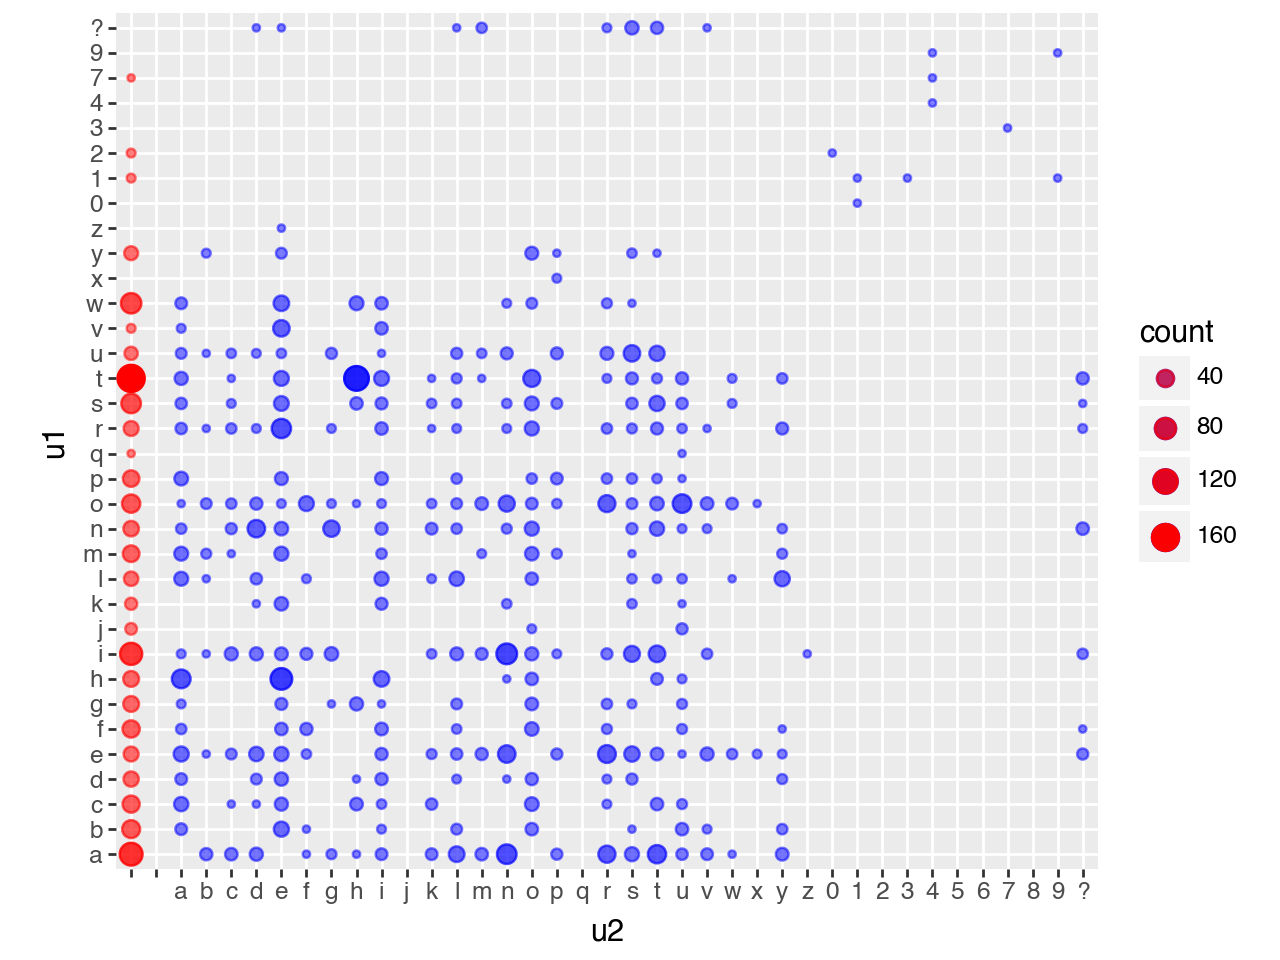

In [10]:
LetterType2 = CategoricalDtype([' ', '  '] + list(string.ascii_lowercase) + list(string.digits) + ['?'], ordered = True)

p = ggplot(bigram_counts
           .reset_index()
           .assign(u1 = lambda df: df['u1'].astype(LetterType2))
           .assign(u2 = lambda df: df['u2'].astype(LetterType2)))
p = p + geom_point(aes(x = 'u2', y = 'u1', size = 'count',  alpha = 'count'), color =  'blue')

# Rugplot does not look good here for showing initial counts. 
# Simple points placed to the first empty slot ' ' are better.   
# p = p + geom_rug(aes(y='u1', size='count', alpha = 'count'), color = 'red', data = start_counts.reset_index())
#
# However, there is a catch. 
# - plotnine converts categories to integers if they are specified through aes mapping
# - plotnine does not convert a category to integer if it is specied outside aes mapping
# Thus we have to do the conversion by ourseleves

p = p + geom_point(aes(y='u1', size='count', alpha = 'count'), x = 1, color = 'red', data = start_counts.reset_index())
p = p + coord_fixed(ratio = 1)
p = p + scale_x_discrete(drop=False)
p = p + scale_alpha(range=(0.5, 1)) 
p = p + scale_size(range=(1, 5))
display(p)

### Parameter estimates with Laplace smoothing 

It is common to take $c=1$ in Laplace smoothing.
Note that counts do not contain entries for missing symbols:
* We must insert missing zeroes or we get $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$ with wrong shapes.
* We must insert missing zeroes before Laplace smoothing or we get wrong values. 

In [11]:
beta = ((start_counts.reindex(LetterType.categories, fill_value=0) + 1)
        .rename(columns = {'count': 'pr'})
        .assign(pr = lambda df: df['pr']/df['pr'].sum())
        )

# Index without gaps
midx = pd.MultiIndex.from_product([LetterType.categories.values]*2, names = ['u1', 'u2'])

alpha = (bigram_counts.reindex(midx, fill_value=0).groupby(['u1'], as_index=True)
         .apply(lambda df: df
                .reset_index('u1', drop=True)
                .assign(pr = lambda ddf: (ddf['count']+1)/(ddf['count']+1).sum()))
        [['pr']])

mdisplay([head(beta.reset_index()), head(alpha.reset_index())], ['beta', 'alpha'])

beta alpha 
 
 
 index 
 pr 
 
 
 
 
 a 
 0.098361 
 
 
 b 
 0.047252 
 
 
 c 
 0.040501 
 
 
 d 
 0.027001 
 
 
 e 
 0.025072 
 
 
 
 
 
 u1 
 u2 
 pr 
 
 
 
 
 0 
 a 
 0.026316 
 
 
 0 
 b 
 0.026316 
 
 
 0 
 c 
 0.026316 
 
 
 0 
 d 
 0.026316 
 
 
 0 
 e 
 0.026316

We must convert $\boldsymbol{\alpha}$ to matrix form for convenience and efficiency. 

In [12]:
alpha = alpha.unstack('u2').pipe(reset_column_index, level=0).fillna(0)
print(alpha.shape)
display(head(alpha))

(37, 37)


u2,a,b,c,d,e,f,g,h,i,j,...,1,2,3,4,5,6,7,8,9,?
u1,,,,,,,,,,,,,,,,,,,,,
0,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,...,0.052632,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316
1,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,...,0.050000,0.025000,0.050000,0.025000,0.025000,0.025000,0.025000,0.025000,0.050000,0.025000
2,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,...,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316
3,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,...,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.052632,0.026316,0.026316,0.026316
4,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316,...,0.026316,0.026316,0.026316,0.052632,0.026316,0.026316,0.026316,0.026316,0.026316,0.026316


## II. Belief propagation in the chain

Let us use belief propagation to compute marginal probabilities for each missing character in the following sequence:

In [13]:
x = ['d', '-', 'm', '-', '-', '-', 'd', 'o', 'r', '-']

### Initialising prior and likelihood values for the chain

Note that this case differs form the problem we considered in the lecture as the evidence occurs also in the middle of the chain and not only in the ends as assumed in the lecture.


<img src = 'illustrations/belief-propagation-in-chain-evidence-i.png' width=100%>

Thus the initialisation and belief propagation rules are slightly different. These are derived in the file  [belief_propagation_in_a_chain.ipynb](belief_propagation_in_a_chain.ipynb) together with other belief propagation rules.


According to more detailed analysis, we can assign  

\begin{align*}
  \pi_V(v)&=[v=v_*]\\
  \lambda_V(v)&= [v=v_*]
  \end{align*}

for all nodes with direct evidence $V=v_*$.
For the initial node $V$ without evidence, we can assign

  \begin{align*} 
  \pi_V(v)&=\beta[v]\\
  \end{align*}

and for the last node $V$ without evidence, we can assign

  \begin{align*}
  \lambda_V(v)&=1\enspace.
  \end{align*}

In [14]:
n = len(x)
Lambda = [None] * n
Pi = [None] * n
Pr = [None] * n

# Processs all direct observations
for i, xi in enumerate(x):
    if xi != '-':
        Pi[i] = Series(0, index = LetterType.categories)
        Pi[i][xi] = 1
        Lambda[i] = Series(0, index = LetterType.categories)
        Lambda[i][xi] = 1

        
# Process the end without direct observation
Lambda[n - 1] = Series(1, index = LetterType.categories)

### Likelihood and prior propagation cycle

During the belief propagation we must update likelihoods and priors that are not set previously: 


* Iterative update rule for prior goes along arrows to forward direction:

\begin{align*}
\pi_B&\propto \pi_A M_{A\to B}
\end{align*}

<img src = 'illustrations/belief-propagation-in-chain-prior-i.png' width=100%>


* Iterative update rule for prior goes against arrows to backward direction:

\begin{align*}
\lambda_D&=M_{D\to E}\lambda_E
\end{align*}

<img src = 'illustrations/belief-propagation-in-chain-likelihood-i.png' width=100%>


In [15]:
for i in range(n-1):
    if Pi[i + 1] is None:
        Pi[i + 1] = Pi[i].dot(alpha).pipe(lambda x: x/x.sum())

for i in reversed(range(1, n)):
    if Lambda[i-1] is None:
        Lambda[i-1] = alpha.dot(Lambda[i]).pipe(lambda x: x/x.sum())

### Posterior propagation cycle

Finally, we can now compute marginal posterior probabilities for each location:

\begin{align*}
p_C\propto \pi_C\otimes\lambda_C
\end{align*}

<img src = 'illustrations/belief-propagation-in-chain-marginal-posterior-i.png' width=100%>


In [16]:
for i in range(n):
    Pr[i] = Pi[i] * Lambda[i]
    Pr[i] = Pr[i]/Pr[i].sum()

### Visualisation

In [17]:
df = (DataFrame(DataFrame(Pr).T.stack())
      .reset_index()
      .rename(columns={'level_0': 'u', 'level_1': 'i', 0: 'pr'}))

We visualize probabilities using circle areas but for clarity we do not show posterior points that have zero probability as they are impossible.

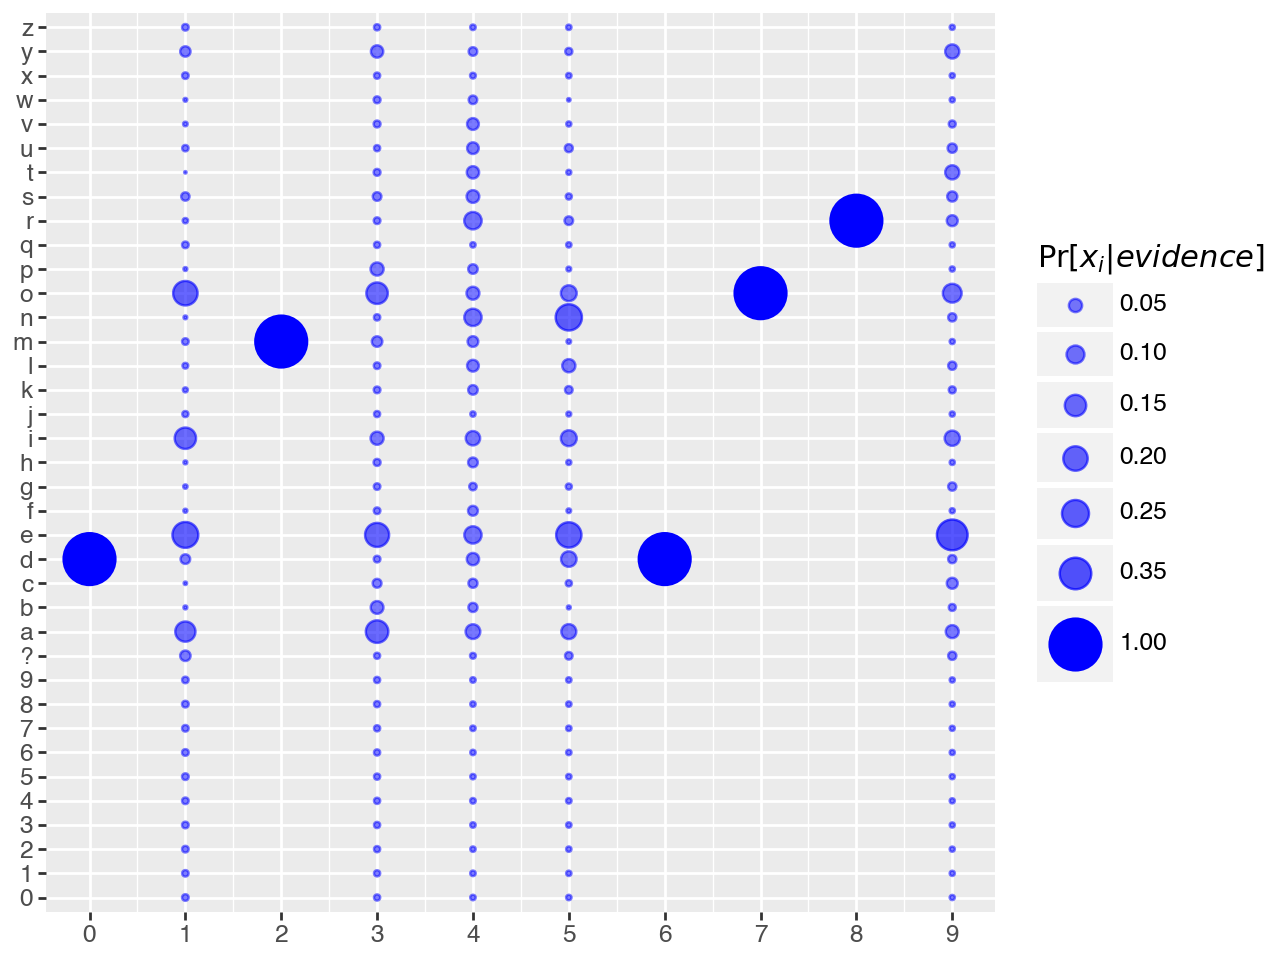

In [18]:
pr_scale =((df['pr']*2).round(1)/2).sort_values().unique().tolist()
p = ggplot(df.loc[df['pr']>0])
p = p + geom_point(aes(x = 'i', y = 'u', size = 'pr', alpha = 'pr'), color = 'blue')
p = p + scale_x_continuous(name='',breaks=list(range(n)))
p = p + scale_y_discrete(name='', drop=False)
p = p + scale_alpha(name='$\Pr[x_i|evidence]$', breaks=pr_scale, range=(0.5, 1)) 
p = p + scale_size_area(name='$\Pr[x_i|evidence]$', breaks=pr_scale, max_size=10)
display(p)

## III. Finding the most probable outcome 

The most naive way to compute the sequence that maximises the posterior probability is to compute the posterior probability

\begin{align*}
p[\boldsymbol{x}|{\color{red}{\mathsf{evidence}}}]\propto\Pr[{\color{red}{\mathsf{evidence}}}|\boldsymbol{x}]\cdot\Pr[\boldsymbol{x}]
\end{align*}

where 
* the probability $\Pr[{\color{red}{\mathsf{evidence}}}|\boldsymbol{x}]$ is a zero-one indicator that shows whether $\color{red}{\mathsf{evidence}}$ is compatible with $\boldsymbol{x}$ 
* the probability $\Pr[\boldsymbol{x}]$ is the probability assigned by Markov chain

This is obviously infeasible. However, we can iteratively prolong candidate sequences:

<img src = 'illustrations/chain-max-i.png' width=100%>



* For each position we will find the most probable subsequence ending with all possible outcomes.
* For the next position we must just prolong the set of candidate sequences found in the previous position. 
* We can always drop sequences that are incompatible with the evidence.

In [19]:
max_pr = [None] * n
prev_letter = [None] * n

### Initialisation

As the first observation is known, there is only one compatible subsequence. 

In [20]:
max_pr[0] = Series(0, index = LetterType.categories)
max_pr[0]['d'] = 1 

### Iterative update rule

As you can guess,

\begin{align*}
\pi_{i+1}^*(v)=
\begin{cases}
\max_u \pi_{i}^*(u)\cdot \alpha[u,v] &\text{if $x_{i+1}$ is unknown}\\
\max_u \pi_{i}^*(u)\cdot \alpha[u,v]\cdot [v=x_{i+1}] & \text{if $x_{i+1}$ is known}
\end{cases}\enspace.
\end{align*}

Technically, we can always compute $\max_u \pi_{i}^*(u)\cdot \alpha[u,v]$ and do the correction $[v=x_{i+1}]$ later on.
The fist update step can be done in parallel by defining a matrix

\begin{align*}
(\pi_{i}^*(u)\cdot \alpha[u,v])_{u\in U, v\in V}\enspace.
\end{align*}

This operation is supported by numpy and is thus much faster than simple for-loop assignment. 

In [21]:
for i in range(n-1):
    
    probs = max_pr[i] * alpha.T
    prev_letter[i + 1] = probs.idxmax(axis=1)
    max_pr[i + 1] = probs.max(axis=1)
    if x[i+1] != '-':
        max_pr[i + 1].loc[max_pr[i + 1].index != x[i+1]] = 0   

Now that we have computed candidates for the entire sequence, we can choose the maximal and go backwards to recover the corresponding assignment.

In [22]:
xmax = [None] * n
xmax[n - 1] = max_pr[9].idxmax()

for i in reversed(range(1,n)):
    xmax[i - 1] = prev_letter[i][xmax[i]]

In [23]:
print(xmax)

['d', 'e', 'm', 'e', 'r', 'e', 'd', 'o', 'r', 'e']


### Visualisation

Let's find the maximal values of marginal posterior probabilities for the maximal posterior solution.

In [24]:
pdf = (df.groupby(['i']).apply(lambda df: df.loc[df['pr'].idxmax(), ['u', 'pr']], include_groups=False)
       .reset_index()
       .rename(columns={'u': 'umax', 'pr': 'upr'})
       .assign(umax = lambda df: df['umax'].astype(LetterType)))
pdf

,i,umax,upr
0,0,d,1.000000
1,1,e,0.226907
2,2,m,1.000000
3,3,e,0.193854
4,4,r,0.094400
5,5,n,0.234895
6,6,d,1.000000
7,7,o,1.000000
8,8,r,1.000000
9,9,e,0.329787


Let's mark the maximal path separately.

In [25]:
mdf = DataFrame({'i': list(range(n)), 'xmax':xmax}).assign(xmax = lambda df: df['xmax'].astype(LetterType))
mdf = pdf.merge(mdf, on='i')
mdf

,i,umax,upr,xmax
0,0,d,1.000000,d
1,1,e,0.226907,e
2,2,m,1.000000,m
3,3,e,0.193854,e
4,4,r,0.094400,r
5,5,n,0.234895,e
6,6,d,1.000000,d
7,7,o,1.000000,o
8,8,r,1.000000,r
9,9,e,0.329787,e


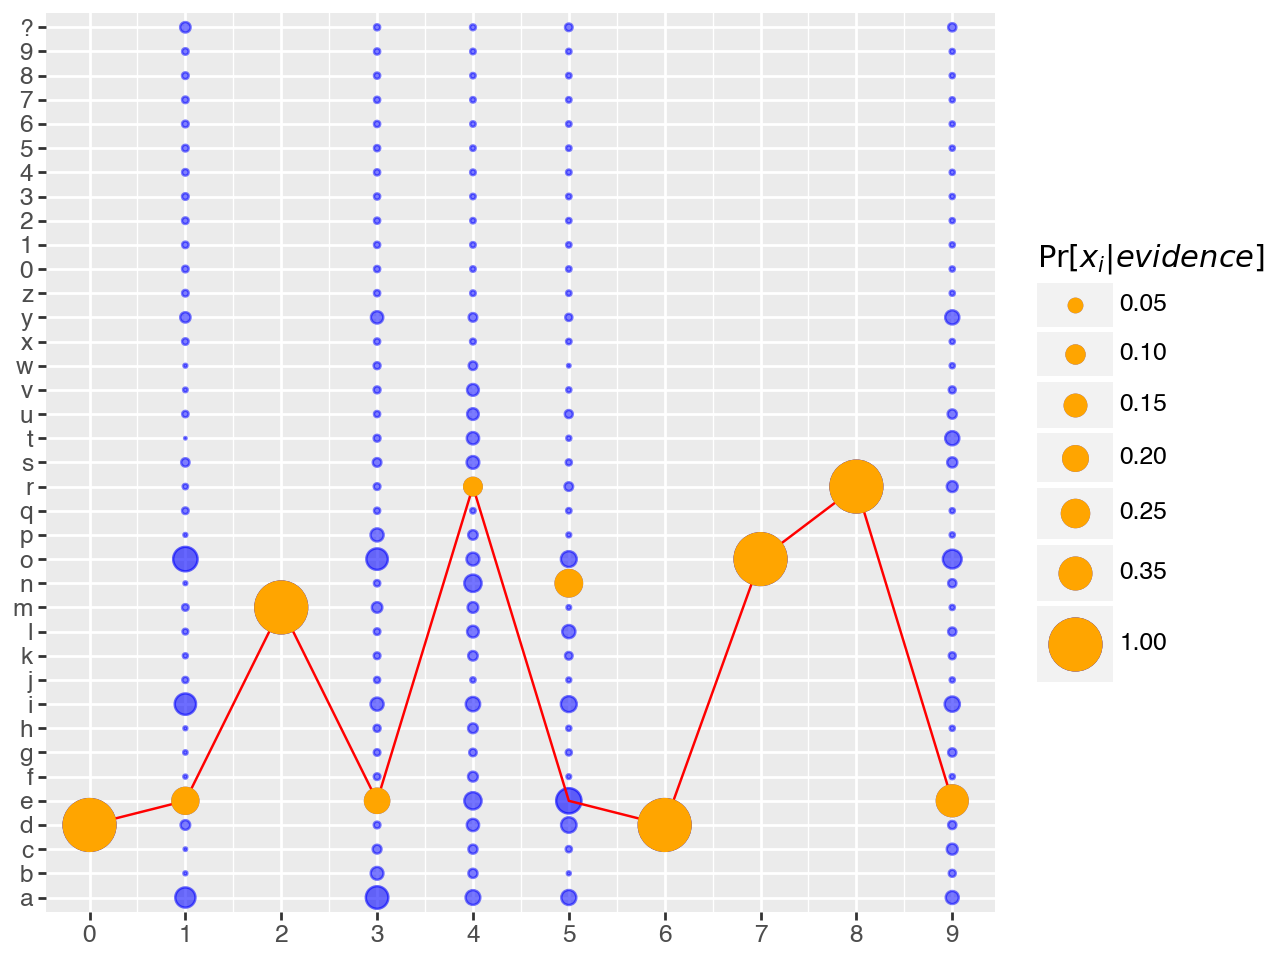

In [26]:
pr_scale =((df['pr']*2).round(1)/2).sort_values().unique().tolist()
p = ggplot(data = mdf)
p = p + geom_point(aes(x = 'i', y = 'u', size = 'pr', alpha = 'pr'), color = 'blue', data = df.loc[df['pr']>0])
p = p + geom_line(aes(x = 'i', y = 'xmax'), group=1, color="red")
p = p + geom_point(aes(x = 'i', y = 'umax', size = 'upr'), color = 'orange') 
p = p + scale_x_continuous(name='',breaks=list(range(n)))
p = p + scale_y_discrete(name='', drop=False)
p = p + scale_alpha(name='$\Pr[x_i|evidence]$', breaks=pr_scale, range=(0.5, 1)) 
p = p + scale_size_area(name='$\Pr[x_i|evidence]$', breaks=pr_scale, max_size=10)
display(p)

# Homework

## 1.1 Function for imputing missing characters (<font color ='red'>1p</font>)

Define a function `impute_characters_1(x:str)` that imputes missing characters in words using belief propagation and outputs the last figure showing marginal posterior distributions for each location together with the maximum aposteriori estimate.
Test it on four different words with missing characters. 

## 1.2 Position dependent imputation (<font color='red'>1p</font>)

The example given above assumed that transition probabilities $\Pr[x_{i+1}|x_i]$ are the same for all positions. The latter is not true as vowels and consonants are usually interleaved in the text.
Download a reasonably large text collection, for instance you can use freely available books form 
[Project Gutenberg](http://www.gutenberg.org) or some news corpora. Split the text into words and train transition matrices for each location separately. Formulae for maximum likelihood and Laplace smoothing are analogous but now location specific.
Define a function `impute_characters_2(x:str)` and compare its output with `impute_characters_2(x:str)`. To make fair comparison you must train both on the same data.

## 1.3 Language detection with Markov chains (<font color='red'>1p</font>)

Use files `est_training_set.csv` and `eng_training_set.csv` in the directory `data` to learn model parameters $\alpha$ and $\beta$ for homogenous Markov chains. Visualise the parameter set as it was done above. Interpret results.

Put these parameters into the formal model to compute probabilities

\begin{align*}
      p_1 &=\Pr[word|\mathsf{Estonian}]\\
      p_2 &=\Pr[word|\mathsf{English}]
\end{align*}

and then use Bayes formula

\begin{align*}
 \Pr[\mathsf{Estonian}|word]
 =\frac{\Pr[word|\mathsf{Estonian}]\Pr[\mathsf{Estonian}]}{\Pr[word]}
\end{align*}
to guess the language of a word on test samples `est_test_set.csv` and `eng_test_set.csv`.
Why the procedure does not work if you use maximum likelihood estimates for the parameters? 

**Hint:** The number of samples is not the problem. You can assume that there are enough samples to estimate all parameters with high accuracy. The same problem could have manifested even if there were millions of word examples.

In [27]:
%config IPCompleter.greedy=True